In [15]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pickle
from MoDE import MoDE
from sklearn.manifold import TSNE, Isomap, MDS
from metrics import distance_metric, correlation_metric, order_preservation
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = loadmat("data/small_stock.mat")["StockData"]
score = loadmat("data/small_stock.mat")["Score"]

In [3]:
#normalize
m = np.mean(data, axis=1)
data = data - m.reshape((-1,1))

s = np.max(data, axis=1) - np.min(data, axis=1)
data = data / s.reshape((-1,1))

In [4]:
data.shape

(436, 128)

In [5]:
# for now using exact distance matrix
from sklearn.metrics import pairwise_distances
dm = pairwise_distances(data, n_jobs=-1)

In [6]:
# temporary: for now limit the decimals
dm = np.round(dm, decimals=5)

In [7]:
mode = MoDE(n_neighbor=20, max_iter=100000, tol=0.0001, verbose=True)

In [8]:
start = time.time()

x_2d_mode = mode.fit_transform(data, score.squeeze(), dm, dm)

print("time: ", time.time() - start)

0.005747126436781609
Start of Gradient Descent algorithm
0 out of 100000 iterations has passed
10000 out of 100000 iterations has passed
20000 out of 100000 iterations has passed
GD stopped after 26000 iteration
end of GD algorithm
time:  21.9882972240448


In [9]:
# mds
mds = MDS()
x_2d_mds = mds.fit_transform(data)

In [10]:
# ISOMAP
isomap = Isomap(n_neighbors=20, n_components=2)
x_2d_isomap = isomap.fit_transform(data)

In [11]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=6.5, n_iter=3000, verbose=1)
x_2d_tsne = tsne.fit_transform(data)

[t-SNE] Computing 20 nearest neighbors...
[t-SNE] Indexed 436 samples in 0.003s...
[t-SNE] Computed neighbors for 436 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 436 / 436
[t-SNE] Mean sigma: 0.417334
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.566101
[t-SNE] KL divergence after 3000 iterations: 1.127500


In [13]:
# load parula colormap for visualization
with open("parula_colormap.pkl", "rb") as f:
    p = pickle.load(f)

from matplotlib.colors import LinearSegmentedColormap
parula_map = LinearSegmentedColormap.from_list('parula', p, N = 2252)

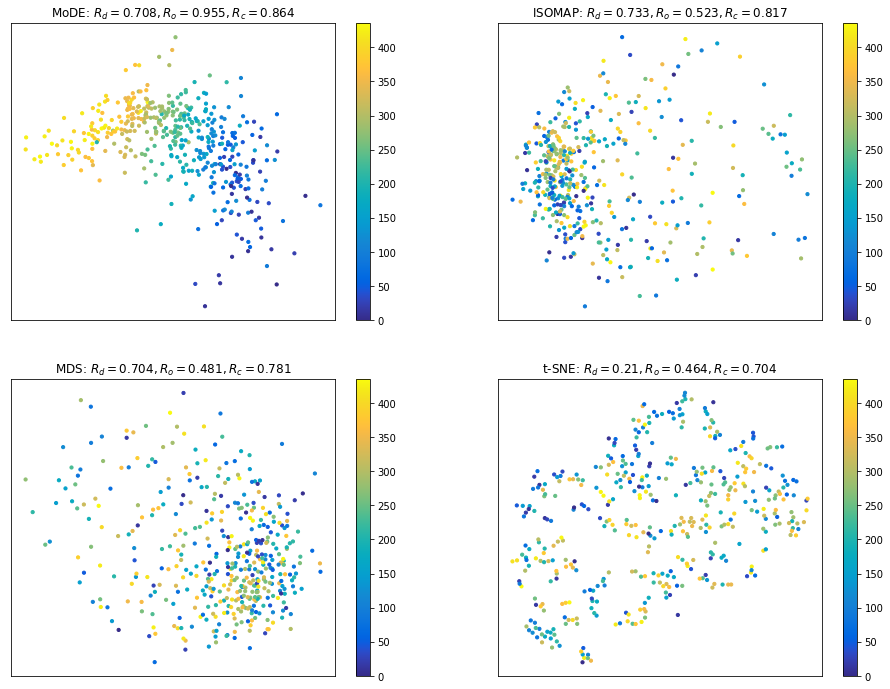

In [16]:
colors = np.argsort(np.argsort(score.squeeze()))
marker_size = 10
fig, ax = plt.subplots(2,2, figsize=(16,12))
p1 = ax[0,0].scatter(x_2d_mode[:, 0], x_2d_mode[:,1], c=colors, cmap=parula_map, s=marker_size)
R_d = distance_metric(data, x_2d_mode, dm, n_neighbor=20)
R_c = correlation_metric(data, x_2d_mode, dm, n_neighbor=20)
R_o = order_preservation(x_2d_mode, dm, n_neighbor=20, score=score.squeeze())
ax[0,0].set_title("MoDE: $R_d={}, R_o={}, R_c={}$".format(np.round(R_d, 3), np.round(R_o, 3), np.round(R_c, 3)))
fig.colorbar(p1, ax=ax[0,0]);

p2 = ax[0,1].scatter(x_2d_isomap[:, 0], x_2d_isomap[:,1], c=colors, cmap=parula_map, s=marker_size)
R_d = distance_metric(data, x_2d_isomap, dm, n_neighbor=20)
R_c = correlation_metric(data, x_2d_isomap, dm, n_neighbor=20)
R_o = order_preservation(x_2d_isomap, dm, n_neighbor=20, score=score.squeeze())
ax[0,1].set_title("ISOMAP: $R_d={}, R_o={}, R_c={}$".format(np.round(R_d, 3), np.round(R_o, 3), np.round(R_c, 3)))
fig.colorbar(p2, ax=ax[0,1]);

p3 = ax[1,0].scatter(x_2d_mds[:, 0], x_2d_mds[:,1], c=colors, cmap=parula_map, s=marker_size)
R_d = distance_metric(data, x_2d_mds, dm, n_neighbor=20)
R_c = correlation_metric(data, x_2d_mds, dm, n_neighbor=20)
R_o = order_preservation(x_2d_mds, dm, n_neighbor=20, score=score.squeeze())
ax[1,0].set_title("MDS: $R_d={}, R_o={}, R_c={}$".format(np.round(R_d, 3), np.round(R_o, 3), np.round(R_c, 3)))
fig.colorbar(p3, ax=ax[1,0]);

p4 = ax[1,1].scatter(x_2d_tsne[:, 0], x_2d_tsne[:,1], c=colors, cmap=parula_map, s=marker_size)
R_d = distance_metric(data, x_2d_tsne, dm, n_neighbor=20)
R_c = correlation_metric(data, x_2d_tsne, dm, n_neighbor=20)
R_o = order_preservation(x_2d_tsne, dm, n_neighbor=20, score=score.squeeze())
ax[1,1].set_title("t-SNE: $R_d={}, R_o={}, R_c={}$".format(np.round(R_d, 3), np.round(R_o, 3), np.round(R_c, 3)))
fig.colorbar(p4, ax=ax[1,1]);
# remove the x and y ticks
for a in ax.reshape((-1)):
    a.set_xticks([])
    a.set_yticks([])
# plt.savefig("figures/ESG.jpg", dpi=1200);
plt.show();